In [1]:
from __future__ import print_function
import glob
from itertools import chain
import os
import cv2
import random
import zipfile
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from functools import reduce
import torch.nn as nn
from einops import rearrange, repeat
import torch.nn.functional as F
import torch.optim as optim
import torchvision
# from linformer import Linformer
from PIL import Image
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import torchvision.transforms as transforms
from skimage import io, img_as_float
import timm

In [2]:
#Import ViT Packages
from utils_ViT import load_pretrained_weights, PRETRAINED_MODELS, as_tuple, resize_positional_embedding_
# from configs import PRETRAINED_MODELS
from transformer import *

# Import 3DDFA Packages
import yaml
from FaceBoxes import FaceBoxes
from TDDFA import TDDFA
# from utils.functions import draw_landmarks
# from utils.render import render
# from utils.depth import depth
# from utils.pncc import pncc
# from utils.uv import uv_tex
# from utils.pose import viz_pose


In [3]:
seed = 17
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [4]:
train_dir_real = '/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/FaceForensics/real/Images/RealTrainSet/real/'
train_dir_fake = '/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/FaceForensics/fake/Images/FakeTrainSet/FaceSwap/'
train_dir_fake_2 = '/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/FaceForensics/fake/Images/FakeTrainSet/Face2Face/'
train_dir_fake_3 = '/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/FaceForensics/fake/Images/FakeTrainSet/Deepfakes/'
train_dir_fake_4 = '/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/FaceForensics/fake/Images/FakeTrainSet/NeuralTextures/'

valid_dir_real = '/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/FaceForensics/real/Images/RealValidationSet/real/'
valid_dir_fake = '/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/FaceForensics/fake/Images/FakeValidationSet/FaceSwap/'
valid_dir_fake_2 = '/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/FaceForensics/fake/Images/FakeValidationSet/Face2Face/'
valid_dir_fake_3 = '/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/FaceForensics/fake/Images/FakeValidationSet/Deepfakes/'
valid_dir_fake_4 = '/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/FaceForensics/fake/Images/FakeValidationSet/NeuralTextures/'


In [5]:
train_list_real = glob.glob(os.path.join(train_dir_real,'*'))
train_list_fake = glob.glob(os.path.join(train_dir_fake,'*'))
train_list_fake_2 = glob.glob(os.path.join(train_dir_fake_2,'*'))
train_list_fake_3 = glob.glob(os.path.join(train_dir_fake_3,'*'))
train_list_fake_4 = glob.glob(os.path.join(train_dir_fake_4,'*'))


valid_list_real = glob.glob(os.path.join(valid_dir_real,'*'))
valid_list_fake = glob.glob(os.path.join(valid_dir_fake,'*'))
valid_list_fake_2 = glob.glob(os.path.join(valid_dir_fake_2,'*'))
valid_list_fake_3 = glob.glob(os.path.join(valid_dir_fake_3,'*'))
valid_list_fake_4 = glob.glob(os.path.join(valid_dir_fake_4,'*'))

In [6]:
np.random.shuffle(train_list_real)
np.random.shuffle(train_list_fake)
np.random.shuffle(train_list_fake_2)
np.random.shuffle(train_list_fake_3)
np.random.shuffle(train_list_fake_4)
np.random.shuffle(train_list_real)
np.random.shuffle(train_list_fake)
np.random.shuffle(train_list_fake_2)
np.random.shuffle(train_list_fake_3)
np.random.shuffle(train_list_fake_4)


np.random.shuffle(valid_list_real)
np.random.shuffle(valid_list_fake)
np.random.shuffle(valid_list_fake_2)
np.random.shuffle(valid_list_fake_3)
np.random.shuffle(valid_list_fake_4)
np.random.shuffle(valid_list_real)
np.random.shuffle(valid_list_fake)
np.random.shuffle(valid_list_fake_2)
np.random.shuffle(valid_list_fake_3)
np.random.shuffle(valid_list_fake_4)

In [7]:
train_list = []
train_list.extend(train_list_real[:100000])
train_list.extend(train_list_fake[:25000])
train_list.extend(train_list_fake_2[:25000])
train_list.extend(train_list_fake_3[:25000])
train_list.extend(train_list_fake_4[:25000])
len(train_list)



200000

In [8]:
valid_list = []
valid_list.extend(valid_list_real[:20000])
valid_list.extend(valid_list_fake[:5000])
valid_list.extend(valid_list_fake_2[:5000])
valid_list.extend(valid_list_fake_3[:5000])
valid_list.extend(valid_list_fake_4[:5000])
len(valid_list)

40000

In [9]:
print(f"Train Data Real: {len(train_list_real)}")
print(f"Train Data Fake: {len(train_list_fake)}")
print(f"Train Data Fake 2: {len(train_list_fake_2)}")
print(f"Train Data Fake 3: {len(train_list_fake_3)}")
print(f"Train Data Fake 4: {len(train_list_fake_4)}")

Train Data Real: 106543
Train Data Fake: 36155
Train Data Fake 2: 36156
Train Data Fake 3: 36121
Train Data Fake 4: 36131


In [10]:
np.random.shuffle(train_list)
np.random.shuffle(train_list)
np.random.shuffle(train_list)
np.random.shuffle(train_list)

np.random.shuffle(valid_list)
np.random.shuffle(valid_list)
np.random.shuffle(valid_list)
np.random.shuffle(valid_list)

In [11]:
labels = [path.split('\\')[-2].split('.')[0].split('/')[-1] for path in train_list]
print(labels[:10])

['Deepfakes', 'real', 'NeuralTextures', 'real', 'FaceSwap', 'real', 'FaceSwap', 'Face2Face', 'real', 'FaceSwap']


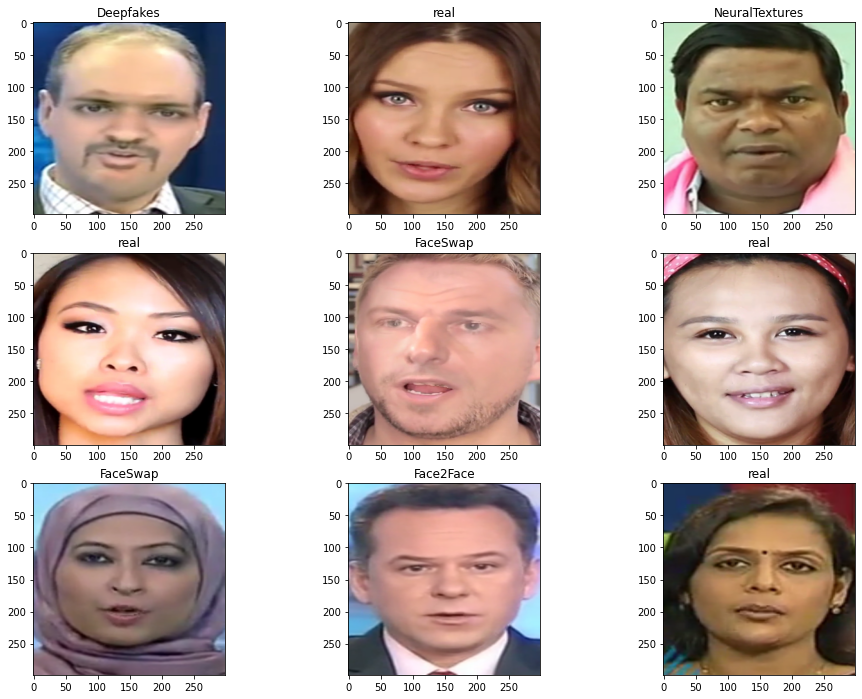

In [12]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [13]:
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
        iaa.Resize((299, 299)),
#         iaa.Crop(px=(0, 16)),
        iaa.Fliplr(0.5), # horizontally flip
        iaa.OneOf([
            iaa.Affine(scale=2),
            iaa.Affine(rotate=20),
            iaa.Affine(translate_px=(-20, 20)),
            iaa.Cutout(fill_mode="constant", cval=0, nb_iterations=2, size=0.4)
        ]),
#         iaa.OneOf([
# #             iaa.JpegCompression(compression=(60, 99)),
# #             iaa.GaussianBlur((0, 2.0)),
# #             iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
# #             iaa.Multiply((0.5, 2.0), per_channel=0.2),
#             iaa.Cutout(fill_mode="constant", cval=0, nb_iterations=1, size=0.5)
#                 ])
        ], random_order=True)
      
    def __call__(self, img):
        img = np.array(img).astype(np.uint8)
        img = self.aug.augment_image(img)
        img = torchvision.transforms.ToTensor()(img)
#         img = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img)
        return img
transforms_imgaug = ImgAugTransform()

# class ImgAugTransform:
#     def __init__(self):
#         self.aug = iaa.Sequential([
#         iaa.Resize((299, 299)),
#         iaa.OneOf([
#             iaa.Cutout(fill_mode="constant", cval=0, nb_iterations=2, size=0.3)
#         ])], random_order=True)
      
#     def __call__(self, img):
#         img = np.array(img).astype(np.uint8)
#         img = self.aug.augment_image(img)
#         img = torchvision.transforms.ToTensor()(img)
# #         img = torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(img)
#         return img
# transforms_imgaug = ImgAugTransform()

train_transforms = transforms.Compose(
    [
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
#         torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
#         torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
    ]
)

In [14]:
class DeepFakeSet(Dataset):
    def __init__(self, file_list, transform=None):

        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split('\\')[-2].split('.')[0].split('/')[-1]
        label = 1 if label == "real" else 0

        return img_transformed, label

In [15]:
# train_data = DeepFakeSet(training_features, training_labels)
# valid_data = DeepFakeSet(validation_features, validation_labels)
# test_data = DeepFakeSet(test_list, transform=test_transforms)

train_data = DeepFakeSet(train_list, transform=train_transforms)
valid_data = DeepFakeSet(valid_list, transform=val_transforms)
# test_data = DeepFakeSet(test_list, transform=test_transforms)

batch_size = 6

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
# # test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

print(len(train_data), len(train_loader))
print(len(valid_data), len(valid_loader))

200000 33334
40000 6667


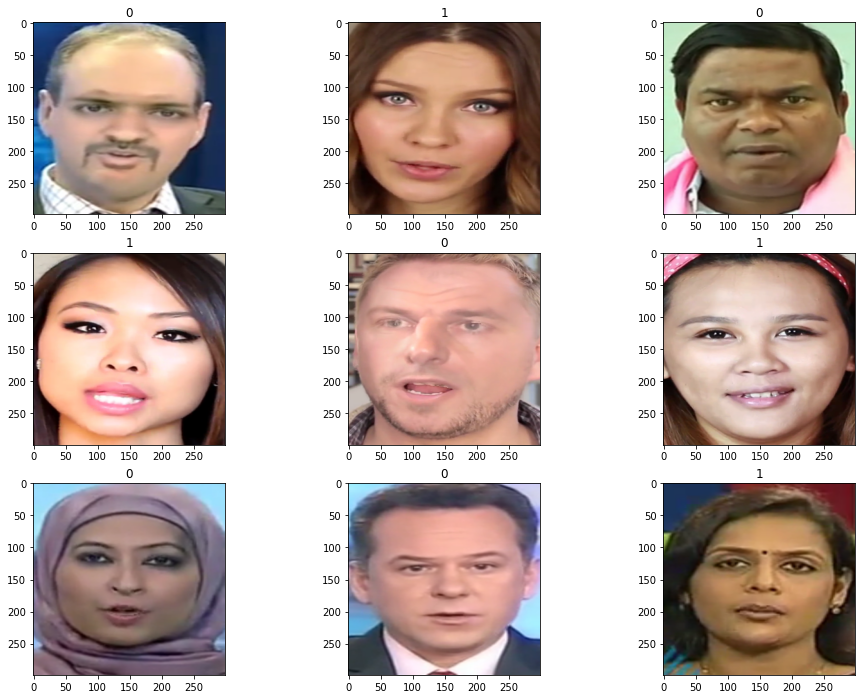

In [16]:
from torchvision.transforms import ToPILImage
to_img = ToPILImage()

random_idx = np.random.randint(1, len(train_data), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = (to_img(train_data[idx][0]))
    ax.set_title(train_data[idx][1])
    ax.imshow(img)

In [17]:
import os.path as osp
import scipy.io as sio

from Sim3DR import rasterize
from utils.functions import plot_image
from utils.io import _load
from utils.tddfa_util import _to_ctype
class DDFA():

    def load_uv_coords(fp):
        C = sio.loadmat(fp)
        uv_coords = C['UV'].copy(order='C').astype(np.float32)
        return uv_coords


    def process_uv(uv_coords, uv_h=256, uv_w=256):
        uv_coords[:, 0] = uv_coords[:, 0] * (uv_w - 1)
        uv_coords[:, 1] = uv_coords[:, 1] * (uv_h - 1)
        uv_coords[:, 1] = uv_h - uv_coords[:, 1] - 1
        uv_coords = np.hstack((uv_coords, np.zeros((uv_coords.shape[0], 1), dtype=np.float32)))  # add z
        return uv_coords


    def get_colors(img, ver):
        # nearest-neighbor sampling
        [h, w, _] = img.shape
        ver[0, :] = np.minimum(np.maximum(ver[0, :], 0), w - 1)  # x
        ver[1, :] = np.minimum(np.maximum(ver[1, :], 0), h - 1)  # y
        ind = np.round(ver).astype(np.int32)
        colors = img[ind[1, :], ind[0, :], :]  # n x 3

        return colors


    def bilinear_interpolate(img, x, y):
        """
        https://stackoverflow.com/questions/12729228/simple-efficient-bilinear-interpolation-of-images-in-numpy-and-python
        """
        x0 = np.floor(x).astype(np.int32)
        x1 = x0 + 1
        y0 = np.floor(y).astype(np.int32)
        y1 = y0 + 1

        x0 = np.clip(x0, 0, img.shape[1] - 1)
        x1 = np.clip(x1, 0, img.shape[1] - 1)
        y0 = np.clip(y0, 0, img.shape[0] - 1)
        y1 = np.clip(y1, 0, img.shape[0] - 1)

        i_a = img[y0, x0]
        i_b = img[y1, x0]
        i_c = img[y0, x1]
        i_d = img[y1, x1]

        wa = (x1 - x) * (y1 - y)
        wb = (x1 - x) * (y - y0)
        wc = (x - x0) * (y1 - y)
        wd = (x - x0) * (y - y0)

        return wa[..., np.newaxis] * i_a + wb[..., np.newaxis] * i_b + wc[..., np.newaxis] * i_c + wd[..., np.newaxis] * i_d


    def uv_tex(img, ver_lst, tri, g_uv_coords,uv_h=299, uv_w=299, uv_c=3, show_flag=False, wfp=None):
        uv_coords = DDFA.process_uv(g_uv_coords, uv_h=uv_h, uv_w=uv_w)

        res_lst = []
        for ver_ in ver_lst:
            ver = _to_ctype(ver_.T)  # transpose to m x 3
            colors = DDFA.bilinear_interpolate(img, ver[:, 0], ver[:, 1]) / 255.
            # `rasterize` here serves as texture sampling, may need to optimization
            res = rasterize(uv_coords, tri, colors, height=uv_h, width=uv_w, channel=uv_c)
            res_lst.append(res)

        # concat if there more than one image
        res = np.concatenate(res_lst, axis=1) if len(res_lst) > 1 else res_lst[0]

        if wfp is not None:
            cv2.imwrite(wfp, res)
            print(f'Save visualization result to {wfp}')

        if show_flag:
            plot_image(res)

        return res

    def load_configs():
        # load config
        cfg = yaml.load(open('configs/mb1_120x120.yml'), Loader=yaml.SafeLoader)
        # Init FaceBoxes and TDDFA, recommend using onnx flag
        onnx_flag = True  # or True to use ONNX to speed up
        if onnx_flag:
            import os
            os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
            os.environ['OMP_NUM_THREADS'] = '4'

            from FaceBoxes.FaceBoxes_ONNX import FaceBoxes_ONNX
            from TDDFA_ONNX import TDDFA_ONNX

            face_boxes = FaceBoxes_ONNX()
            tddfa = TDDFA_ONNX(**cfg)
        else:
            tddfa = TDDFA(gpu_mode=False, **cfg)
            face_boxes = FaceBoxes()
        return tddfa, face_boxes
    
    def generate_uv_tex(x, feature_extractor, sequence_embedding, linear_1, proj, seq_embed):
        tddfa, face_boxes = DDFA.load_configs()
        to_pil_image = transforms.ToPILImage()
        to_tensor = transforms.ToTensor()
        to_normalized = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        b, c, fh, fw = x.shape
        all_concated_feats = torch.zeros(1, 324, 768).to(device)
        for i in range(b):
#         img = x.cpu()
#             image = x[i].unsqueeze(0)
#             image_features = feature_extractor(image)
#             image_features = image_features[-1].flatten(2)
#             image_features = linear_1(image_features)
#             image_features = image_features.transpose(2,1)
#             image_features = proj(image_features)

            image = x[i].unsqueeze(0)
            image = to_normalized(image)
            image_features = feature_extractor(image)
            image_features = image_features[-1]
            print(image_features.shape)
            image_features = proj(image_features).flatten(2)
            print(image_features.shape)
            image_features = linear_1(image_features)
            image_features = image_features.transpose(2,1)
#             image_features = linear_2(image_features)
            if seq_embed==True:
                image_features = sequence_embedding(image_features)
    
            img = to_pil_image(x[i])
            img = np.asarray(img)
            boxes = face_boxes(img)
            
            if len(boxes) == 0 or len(boxes)>1:
                uv_features = feature_extractor(torch.zeros_like(image).to(device))
                uv_features = uv_features[-1]
                uv_features = proj(uv_features).flatten(2)
                uv_features = linear_1(uv_features)
                uv_features = uv_features.transpose(2,1)
#                 patch_embedding_uv_texture = patch_embedding(torch.zeros_like(image).to(device))
#                 patch_embedding_uv_texture = patch_embedding_uv_texture.flatten(2).transpose(1, 2)
                if seq_embed==True:
                    uv_features = sequence_embedding(uv_features)
                uv_features = torch.cat((image_features, uv_features), dim=1)
            else:
                param_lst, roi_box_lst = tddfa(img, boxes)
                g_uv_coords = DDFA.load_uv_coords(('configs/BFM_UV.mat'))
                indices = _load(('configs/indices.npy'))  # todo: handle bfm_slim
                g_uv_coords = g_uv_coords[indices, :]
                ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=True)
                uv_tensor = to_tensor(DDFA.uv_tex(img, ver_lst, tddfa.tri, g_uv_coords, show_flag=False, wfp=None))
                uv_tensor = uv_tensor.unsqueeze(0)
                uv_tensor = to_normalized(uv_tensor)
                uv_features = feature_extractor(uv_tensor.to(device))
                uv_features = uv_features[-1]
                uv_features = proj(uv_features).flatten(2)
                uv_features = linear_1(uv_features)
                uv_features = uv_features.transpose(2,1)
#                 patch_embedding_uv_texture = patch_embedding(uv_tensor.to(device))
#                 patch_embedding_uv_texture = patch_embedding_uv_texture.flatten(2).transpose(1, 2)

                
                if seq_embed==True:
                    uv_features = sequence_embedding(uv_features)
                uv_features = torch.cat((image_features, uv_features), dim=1)
            
            all_concated_feats = torch.cat((all_concated_feats, uv_features), dim=0)
        return all_concated_feats[1:]

In [18]:
# """model.py - Model and module class for ViT.
#    They are built to mirror those in the official Jax implementation.
# """

# from typing import Optional
# import torch
# from torch import nn
# from torch.nn import functional as F


# # from transformer import Transformer
# # from utils_ViT import load_pretrained_weights, as_tuple
# # from configs import PRETRAINED_MODELS

# class Transformer(nn.Module):
#     """Transformer with Self-Attentive Blocks"""
#     def __init__(self, num_layers, dim, num_heads, ff_dim, dropout):
#         super().__init__()
#         self.blocks = nn.ModuleList([
#             Block(dim, num_heads, ff_dim, dropout) for _ in range(num_layers)])

#     def forward(self, x, mask=None):
#         for block in self.blocks:
#             x = block(x, mask)
#         return x
    

# class PositionalEmbedding1D(nn.Module):
#     """Adds (optionally learned) positional embeddings to the inputs."""

#     def __init__(self, seq_len, dim):
#         super().__init__()
#         self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, dim))
    
#     def forward(self, x):
#         """Input has shape `(batch_size, seq_len, emb_dim)`"""
#         return x + self.pos_embedding
    
# class SequenceEmbedding(nn.Module):
#     """Adds (optionally learned) sequence embeddings to the inputs."""

#     def __init__(self, seq_len, dim):
#         super().__init__()
#         self.seq_embedding = nn.Parameter(torch.zeros(1, 162, dim))
    
#     def forward(self, x):
#         """Input has shape `(batch_size, seq_len, emb_dim)`"""
#         return x + self.seq_embedding


# class ImageTransformer(nn.Module):
#     """
#     Args:
#         name (str): Model name, e.g. 'B_16'
#         pretrained (bool): Load pretrained weights
#         in_channels (int): Number of channels in input data
#         num_classes (int): Number of classes, default 1000

#     References:
#         [1] https://openreview.net/forum?id=YicbFdNTTy
#     """

#     def __init__(
#         self, 
#         name: Optional[str] = None, 
#         pretrained: bool = False, 
#         patches: int = 16,
#         dim: int = 768,
#         ff_dim: int = 3072,
#         num_heads: int = 12,
#         num_layers: int = 12,
#         attention_dropout_rate: float = 0.0,
#         dropout_rate: float = 0.1,
#         representation_size: Optional[int] = None,
#         load_repr_layer: bool = False,
#         classifier: str = 'token',
#         positional_embedding: str = '1d',
#         in_channels: int = 3, 
#         image_size: Optional[int] = None,
#         num_classes: Optional[int] = None,
#         seq_embed: bool = True, 
#         hybrid: bool = True,
#     ):
#         super().__init__()

#         # Configuration
#         if name is None:
#             check_msg = 'must specify name of pretrained model'
#             assert not pretrained, check_msg
#             assert not resize_positional_embedding, check_msg
#             if num_classes is None:
#                 num_classes = 1000
#             if image_size is None:
#                 image_size = 384
#         else:  # load pretrained model
#             assert name in PRETRAINED_MODELS.keys(), \
#                 'name should be in: ' + ', '.join(PRETRAINED_MODELS.keys())
#             config = PRETRAINED_MODELS[name]['config']
#             patches = config['patches']
#             dim = config['dim']
#             ff_dim = config['ff_dim']
#             num_heads = config['num_heads']
#             num_layers = config['num_layers']
#             attention_dropout_rate = config['attention_dropout_rate']
#             dropout_rate = config['dropout_rate']
#             representation_size = config['representation_size']
#             classifier = config['classifier']
#             if image_size is None:
#                 image_size = PRETRAINED_MODELS[name]['image_size']
#             if num_classes is None:
#                 num_classes = PRETRAINED_MODELS[name]['num_classes']
#         self.seq_embed=seq_embed
#         self.hybrid=hybrid
#         self.image_size = image_size                
# #         print(hybrid)
#         # Image and patch sizes
#         h, w = as_tuple(image_size)  # image sizes
#         fh, fw = as_tuple(patches)  # patch sizes
#         gh, gw = h // fh, w // fw  # number of patches
#         seq_len = gh * gw
        
#         if self.hybrid == False:
#             # Patch embedding
#             self.patch_embedding = nn.Conv2d(in_channels, dim, kernel_size=(16,32), stride=(16, 32))
#         else:
#             #Get CNN feature extractor
#             self.xception_feature_extractor = timm.create_model('xception', features_only=True, pretrained=True).eval()
            
#         self.sequence_embedding = SequenceEmbedding(162, dim)
#         self.linear_1 = torch.nn.Linear(100, 162)
#         self.proj = nn.Conv2d(2048, 768, 1)
                
# #       Class token
#         if classifier == 'token':
#             self.class_token = nn.Parameter(torch.zeros(1, 1, dim))
#             seq_len += 1
        
# #       Positional embedding
#         if positional_embedding.lower() == '1d':
#             self.positional_embedding = PositionalEmbedding1D(seq_len, dim)
#         else:
#             raise NotImplementedError()
                    
#         #Transformer
#         self.transformer = Transformer(num_layers=num_layers, dim=dim, num_heads=num_heads, 
#                                        ff_dim=ff_dim, dropout=dropout_rate)
        
#         # Representation layer
#         if representation_size and load_repr_layer:
#             self.pre_logits = nn.Linear(dim, representation_size)
#             pre_logits_size = representation_size
#         else:
#             pre_logits_size = dim

#         # Classifier head
#         self.norm = nn.LayerNorm(pre_logits_size, eps=1e-6)
#         self.fc = nn.Linear(pre_logits_size, num_classes)

#         # Initialize weights
#         self.init_weights()
        
#         # Load pretrained model
#         if pretrained:
#             pretrained_num_channels = 3
#             pretrained_num_classes = PRETRAINED_MODELS[name]['num_classes']
#             pretrained_image_size = PRETRAINED_MODELS[name]['image_size']
#             load_pretrained_weights(
#                 self, name, 
#                 load_fc=(num_classes == pretrained_num_classes),
#                 load_repr_layer=load_repr_layer,
#                 resize_positional_embedding=(image_size != pretrained_image_size),
#             )
        
#     @torch.no_grad()
#     def init_weights(self):
#         def _init(m):
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_uniform_(m.weight)  # _trunc_normal(m.weight, std=0.02)  # from .initialization import _trunc_normal
#                 if hasattr(m, 'bias') and m.bias is not None:
#                     nn.init.normal_(m.bias, std=1e-6)  # nn.init.constant(m.bias, 0)
#         self.apply(_init)
#         nn.init.constant_(self.fc.weight, 0)
#         nn.init.constant_(self.fc.bias, 0)
#         nn.init.normal_(self.positional_embedding.pos_embedding, std=0.02)  # _trunc_normal(self.positional_embedding.pos_embedding, std=0.02)
#         nn.init.constant_(self.class_token, 0)

#     def forward(self, x):
#         """Breaks image into patches, applies transformer, applies MLP head.
#         print(data.shape)
#          Args:
#             x (tensor): `b,c,fh,fw`
#         """
#         b, c, fh, fw = x.shape
#         x = DDFA.generate_uv_tex(x, self.xception_feature_extractor, self.sequence_embedding, self.linear_1, self.proj, self.seq_embed)
#         if hasattr(self, 'class_token'):
#             x = torch.cat((self.class_token.expand(b, -1, -1), x), dim=1)  # b,gh*gw+1,d
#         if hasattr(self, 'positional_embedding'): 
#             x = self.positional_embedding(x)  # b,gh*gw+1,d 

#         x = self.transformer(x)  # b,gh*gw+1,d
#         if hasattr(self, 'pre_logits'):
#             x = self.pre_logits(x)
#             x = torch.tanh(x)
#         if hasattr(self, 'fc'):
#             x = self.norm(x)[:, 0]  # b,d
#             x = self.fc(x)  # b,num_classes
#         return x
        


In [25]:
from models.imagetransformer import ImageTransformer

In [26]:
device = 'cuda'
model = ImageTransformer('B_16_imagenet1k', pretrained=True, image_size = 300, num_classes = 2,
                        seq_embed=True, hybrid=True).to(device)

NameError: name 'PRETRAINED_MODELS' is not defined

In [20]:
epochs = 30
lr = 3e-3
# gamma = 0.7

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [21]:
# NO SegEmbed f2f only eval on with_new_train_valid_strategy
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
#         print("HERE")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(valid_loader):
            data = data.to(device)
            label = label.to(device)
#             print(data.shape)aa
            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    
#     if epoch == 1:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/new_ensemble_vit_2epochs_fs_df_f2f_nt.pth")
#         torch.save(model.state_dict(), PATH)
#     elif epoch == 2:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/new_ensemble_vit_3epochs_fs_df_f2f_nt.pth")
#         torch.save(model.state_dict(), PATH)
#     elif epoch == 3:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/new_ensemble_vit_4epochs_fs_df_f2f_nt.pth")
#         torch.save(model.state_dict(), PATH)
#     elif epoch == 4:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/new_ensemble_vit_5epochs_fs_df_f2f_nt.pth")
#         torch.save(model.state_dict(), PATH)
#     elif epoch == 5:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/new_ensemble_vit_6epochs_fs_df_f2f_nt.pth")
#         torch.save(model.state_dict(), PATH)
#     elif epoch == 6:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/new_ensemble_vit_7epochs_fs_df_f2f_nt.pth")
#         torch.save(model.state_dict(), PATH)
#     elif epoch == 7:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/new_ensemble_vit_8epochs_fs_df_f2f_nt.pth")
#         torch.save(model.state_dict(), PATH)
        
        
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/33334 [00:00<?, ?it/s]

torch.Size([1, 2048, 10, 10])
torch.Size([1, 768, 100])
here and yes
torch.Size([1, 2048, 10, 10])
torch.Size([1, 768, 100])
here and yes
torch.Size([1, 2048, 10, 10])
torch.Size([1, 768, 100])
here and yes
torch.Size([1, 2048, 10, 10])
torch.Size([1, 768, 100])
here and yes
torch.Size([1, 2048, 10, 10])
torch.Size([1, 768, 100])
here and yes
torch.Size([1, 2048, 10, 10])
torch.Size([1, 768, 100])
here and yes
torch.Size([1, 2048, 10, 10])
torch.Size([1, 768, 100])
here and yes
torch.Size([1, 2048, 10, 10])
torch.Size([1, 768, 100])
here and yes
torch.Size([1, 2048, 10, 10])
torch.Size([1, 768, 100])
here and yes
torch.Size([1, 2048, 10, 10])
torch.Size([1, 768, 100])
here and yes
torch.Size([1, 2048, 10, 10])
torch.Size([1, 768, 100])
here and yes
torch.Size([1, 2048, 10, 10])
torch.Size([1, 768, 100])
here and yes
torch.Size([1, 2048, 10, 10])
torch.Size([1, 768, 100])
here and yes
torch.Size([1, 2048, 10, 10])
torch.Size([1, 768, 100])
here and yes
torch.Size([1, 2048, 10, 10])
torc

KeyboardInterrupt: 